In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

# import sys
# from pathlib import Path
# sys.path.append(str(Path().cwd().parent))

from utils import MinMaxScaler, get_ticket, MakeTimeSeries
from agent import Agent_xgb

from indicators import *

In [2]:
data = get_ticket("MGLU3.SA")
# data = get_ticket("VALE3.SA")
# data = data[-252:]

In [3]:
data.head()

,_Open,_High,_Low,_Close,_Volume
Date,,,,,
2011-05-02,4.207495,4.338162,4.207495,4.298963,29936513
2011-05-03,4.312029,4.361683,4.233629,4.259763,3599867
2011-05-04,4.264989,4.306802,4.264989,4.306802,4191406
2011-05-05,4.288509,4.288509,4.264990,4.280669,3752456
2011-05-06,4.272829,4.280669,4.181362,4.249309,4134612


In [4]:
preprocessor = Pipeline(steps=[
    # ("Scaler", MinMaxScaler(cols_list=["_Open", "_High", "_Low", "_Close"])),
    ("SMA", SimpleMovingAverage(short=7, middle=23, long=71, graphic=True)),
    ("RSI/IFR", RelativeStrengthIndex(window=14, graphic=True)),
    ("AO", AwesomeOscillator(short=5, long=34, graphic=True)),
    ("MACD", MovingAverageConvergenceDivergence(short=12, long=26, signal=9, graphic=True)),
    ("ADX/DMI", AverageDirectionalIndex(window=14, threshold=20, graphic=True)),
    # ("OBV", OnBalanceVolume()), # Transformar num sinal!
    ("BB", BollingerBands(window=40, entry_threshold=0.5, out_tp_threshold=1.5, out_sl_threshold=0, graphic=True)),
    ("Ichimoku", IchimokuClouds(window1=9, window2=26, window3=52, graphic=True)),
    # ("VWAP", VolumeWeightedAveragePrice(graphic=True)),  # Transformar num sinal!
    ("Par.SAR", ParabolicSAR(acceleration=0.02, maximum=0.2, graphic=True)),
    ("Aleatory", Aleatory(lack_trend=150, graphic=True)),
    ("Trend", Trend(short=23, long=71, graphic=True)),
    ("MakeTimeSeries", MakeTimeSeries(window=1, indicators=None)) # indicators=['SMA', ...]
])

In [5]:
_ = preprocessor.fit(data)
data_preprocessed = preprocessor.transform(data)

In [6]:
data_preprocessed.head()

,_Open,_High,_Low,_Close,_Volume,SMA D-0,RSI D-0,AO D-0,MACD D-0,ADX D-0,BB D-0,Ichimoku D-0,pSAR_ind D-0,Aleatory D-0,Trend
Date,,,,,,,,,,,,,,,
2011-06-16,4.312029,4.408722,4.178748,4.390429,2052423,0,72.321545,0.181028,0.018362,1,0,0.10584,0.015617,0,0
2011-06-17,4.364296,4.374750,4.194429,4.312029,811526,0,61.506303,0.155072,0.006646,1,0,0.10584,0.017074,0,0
2011-06-20,4.267602,4.285896,4.189202,4.233629,820422,0,53.787933,0.093335,-0.006447,1,0,0.10584,0.013697,0,0
2011-06-21,4.207494,4.359068,4.204880,4.338161,637383,0,57.042181,0.055557,-0.008028,1,0,0.10584,0.014629,0,0
2011-06-22,4.275441,4.359068,4.244081,4.246695,1114651,0,47.491556,0.031306,-0.014800,1,0,0.10584,0.021821,0,0


In [7]:
sample = data_preprocessed.iloc[-500:].copy()
data_preprocessed.drop(sample.index, inplace=True)

In [8]:
sample.sample(5)

,_Open,_High,_Low,_Close,_Volume,SMA D-0,RSI D-0,AO D-0,MACD D-0,ADX D-0,BB D-0,Ichimoku D-0,pSAR_ind D-0,Aleatory D-0,Trend
Date,,,,,,,,,,,,,,,
2024-08-30,12.377419,12.406542,11.775537,11.804660,25198000,1,43.894893,0.509116,-0.080998,-1,0,0.732937,0.043356,0,0
2024-05-31,11.726998,12.027940,11.066869,12.027940,63751700,-1,20.079540,-2.186478,-0.297265,-1,0,-0.631006,-0.412166,0,0
2023-06-29,30.508508,31.779696,30.417707,31.325699,8462453,0,24.999980,-2.797949,-0.460587,-1,0,-1.770584,-0.205393,1,1
2023-10-04,17.161036,17.705832,16.979437,17.161036,14026272,-1,19.999982,-5.136293,-0.306938,-1,0,-2.633175,-0.454642,1,0
2024-03-13,19.609717,20.192182,19.221404,19.706793,8056880,0,43.333336,-0.121601,-0.173070,1,0,0.388311,0.032256,1,0


In [9]:
despise = ['_Open', '_High', '_Low', '_Close', '_Volume', 'Aleatory D-0']
# despise = ['_Open', '_High', '_Low', '_Close', '_Volume', 'Aleatory D-0', 'Aleatory D-1', 'Aleatory D-2', 'Aleatory D-3', 'Aleatory D-4', 'Aleatory D-5']

In [10]:
agent = Agent_xgb(data = data_preprocessed, drop_intersection_time_series = None, despise = despise)


                Task: regression

                Total of registers: 2948
                Total of valid registers: 2948
                Total of invalid registers: 0

                Total of training registers: 2063
                Total of validation registers: 442
                Total of test registers: 443

                Features before preprocessing: 8
                Features after preprocessing: 8

                Numerical Features: ['SMA D-0', 'RSI D-0', 'AO D-0', 'MACD D-0', 'ADX D-0', 'BB D-0', 'Ichimoku D-0', 'pSAR_ind D-0']
                Categorical Features: []
                Categorical Features removed due to high cardinality: []

                Target: ['Trend']
            


### Results Optimum

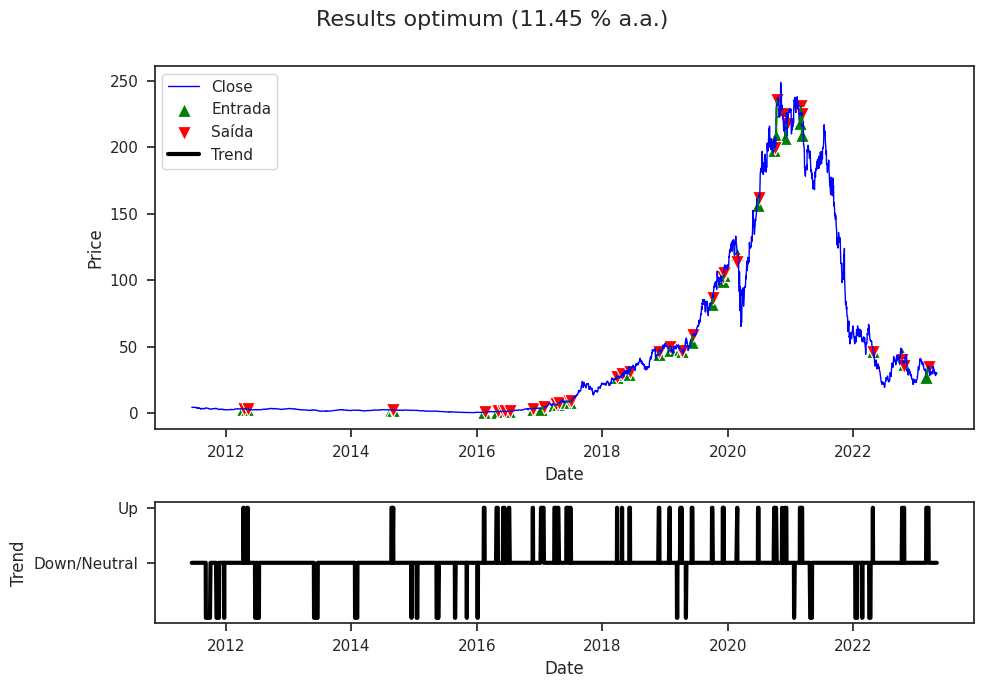

In [11]:
agent.optimum_choice(data_preprocessed)

### Naive Choice

##### Aleatory

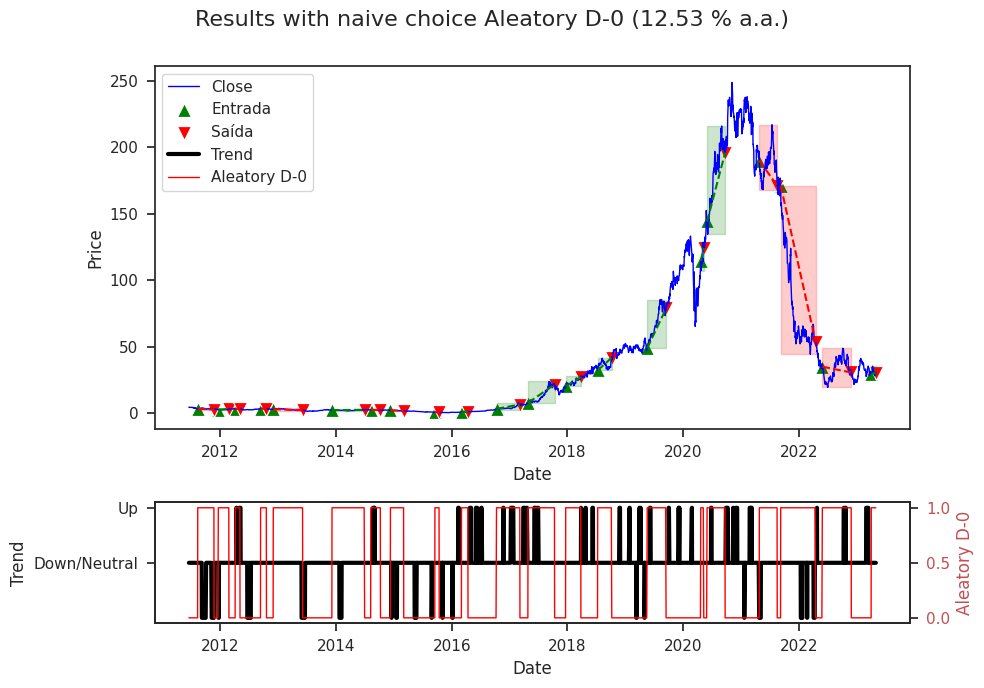

In [12]:
agent.naive_choice(data_preprocessed, signal="Aleatory D-0", policy={"entry": lambda signal: signal > 0.5, "out": lambda signal: signal <= 0.5})

##### SMA

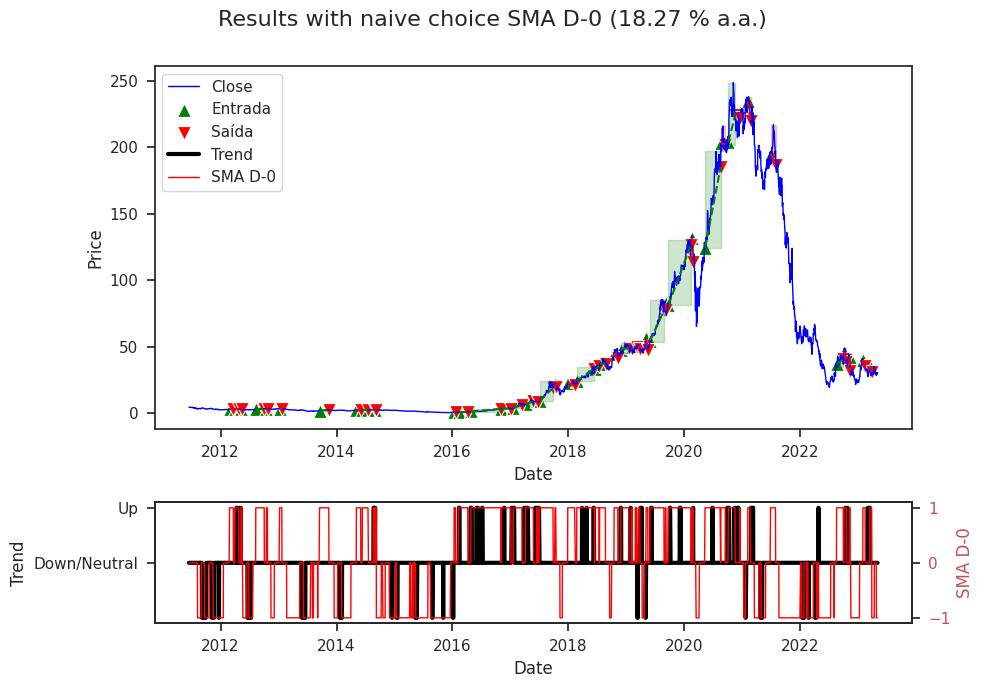

In [13]:
agent.naive_choice(data_preprocessed, signal="SMA D-0", policy={"entry": lambda signal: signal > 0.5, "out": lambda signal: signal <= 0.5})

##### RSI

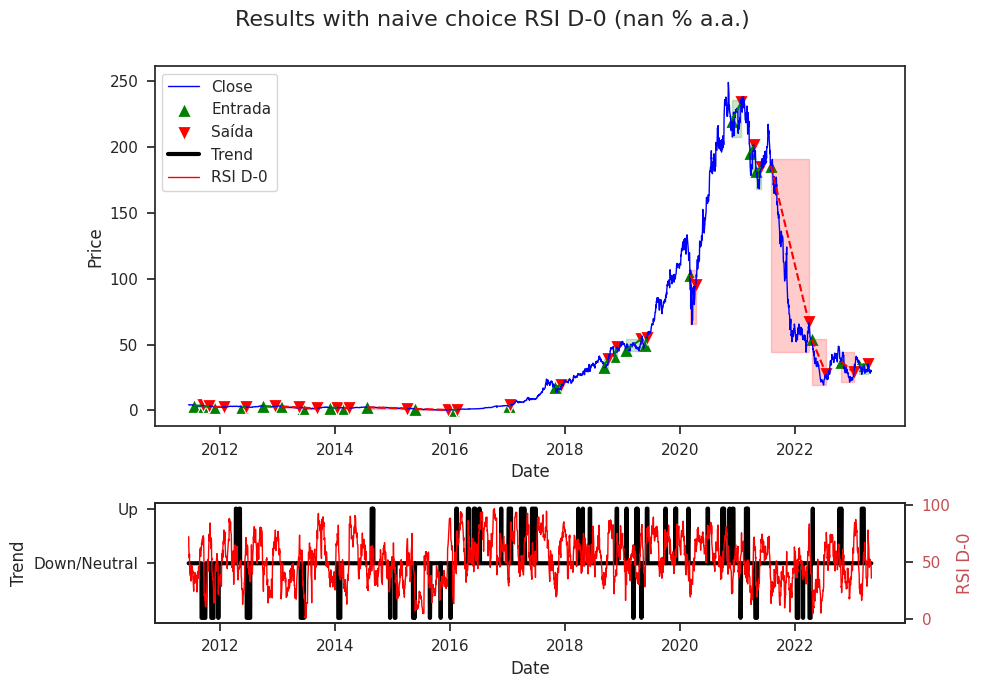

In [14]:
agent.naive_choice(data_preprocessed, signal="RSI D-0", policy={"entry": lambda signal: signal < 30, "out": lambda signal: signal > 70})

##### AO

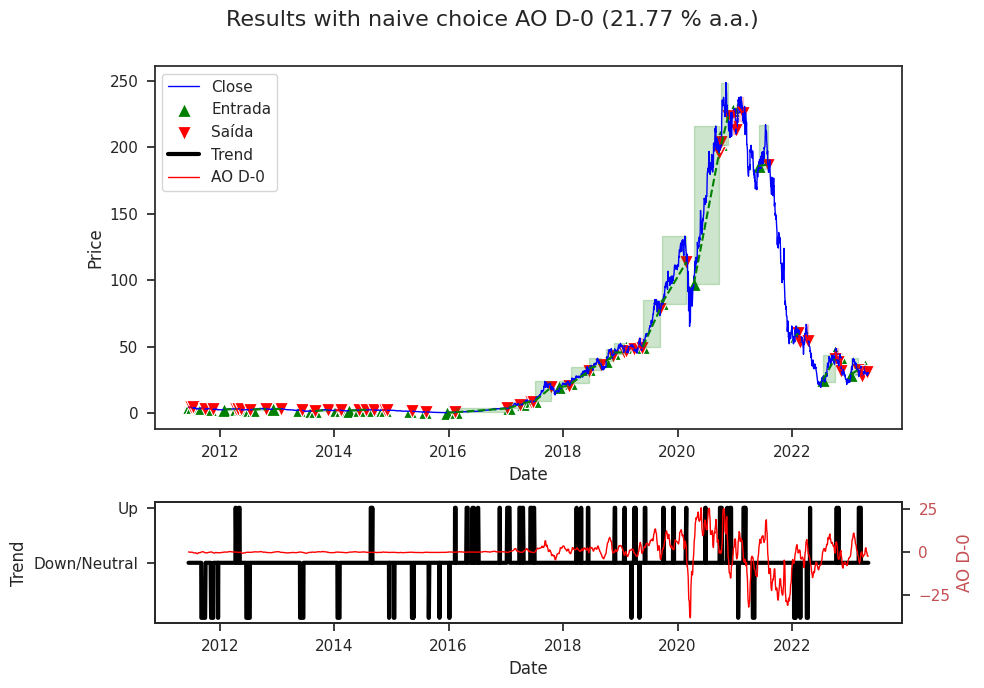

In [15]:
agent.naive_choice(data_preprocessed, signal="AO D-0", policy={"entry": lambda signal: signal > 0, "out": lambda signal: signal <= 0})

##### MACD

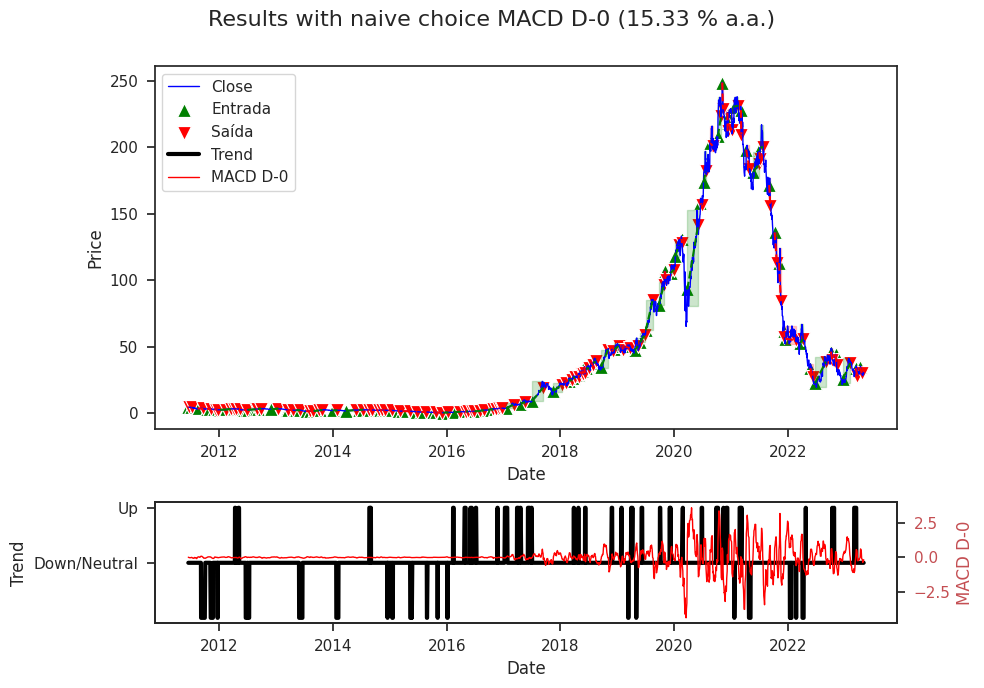

In [16]:
agent.naive_choice(data_preprocessed, signal="MACD D-0", policy={"entry": lambda signal: signal > 0, "out": lambda signal: signal <= 0})

##### ADX

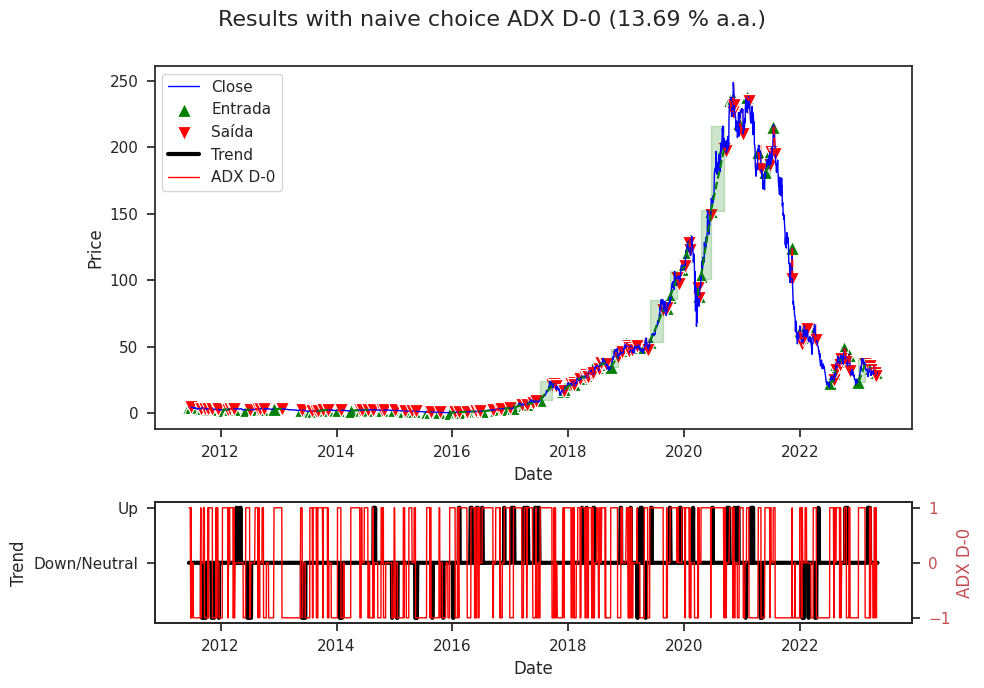

In [17]:
agent.naive_choice(data_preprocessed, signal="ADX D-0", policy={"entry": lambda signal: signal > 0.5, "out": lambda signal: signal <= 0.5})

##### BB

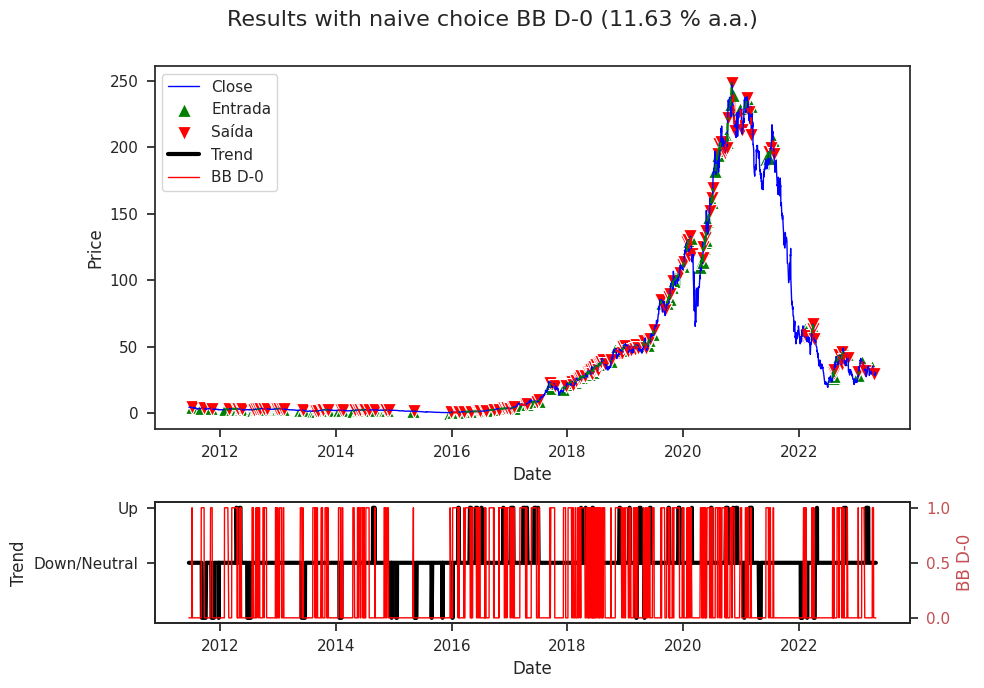

In [18]:
agent.naive_choice(data_preprocessed, signal="BB D-0", policy={"entry": lambda signal: signal > 0.5, "out": lambda signal: signal <= 0.5})

##### Ichimoku

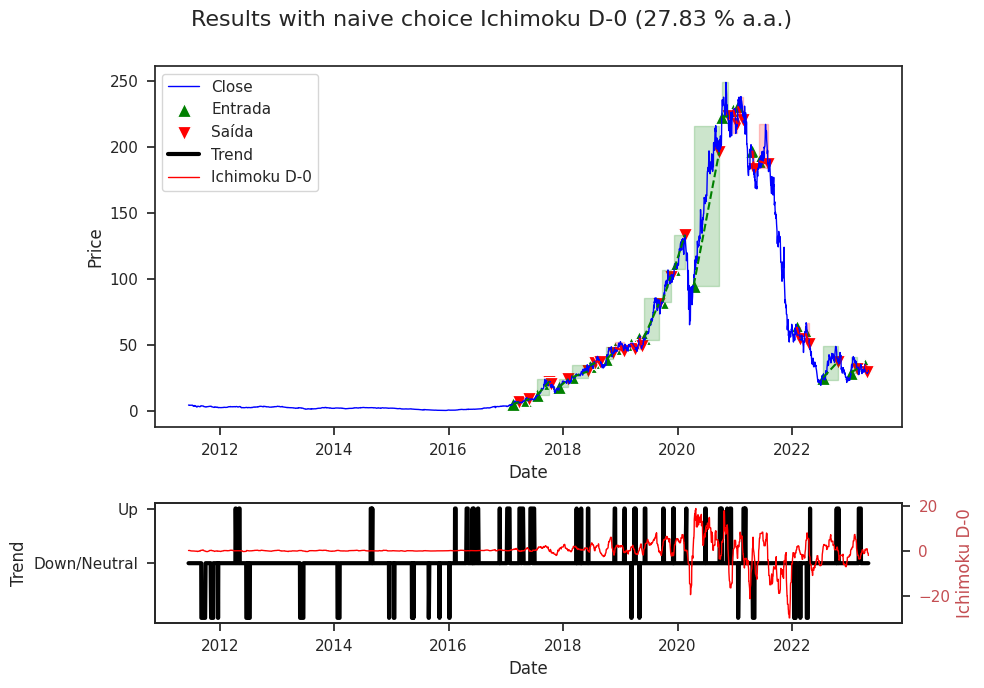

In [19]:
agent.naive_choice(data_preprocessed, signal="Ichimoku D-0", policy={"entry": lambda signal: signal > 0.5, "out": lambda signal: signal <= 0})

##### Parabolic SAR

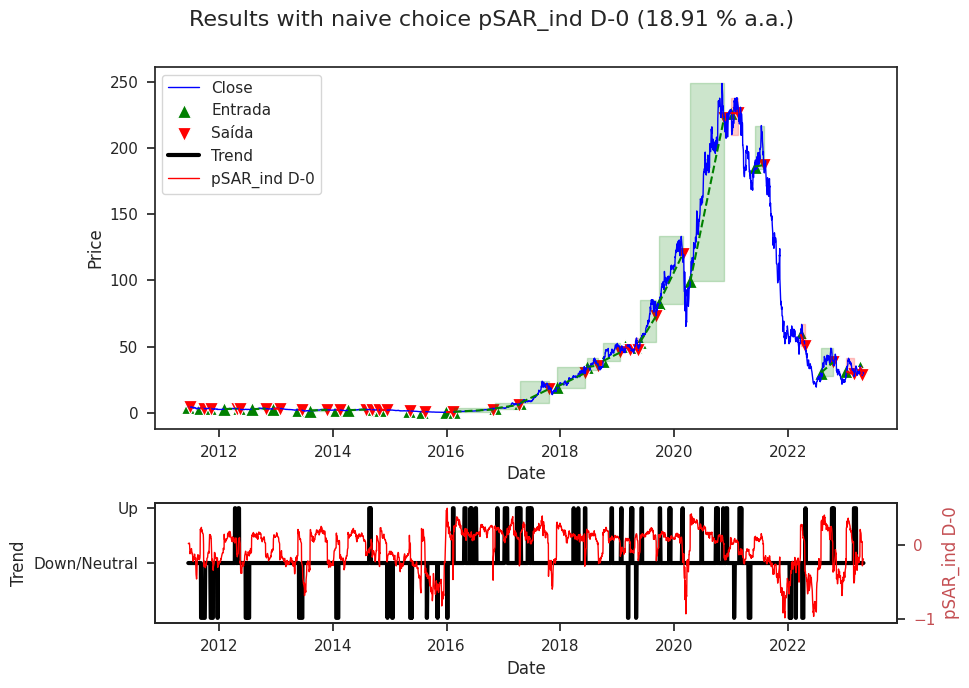

In [20]:
agent.naive_choice(data_preprocessed, signal="pSAR_ind D-0", policy={"entry": lambda signal: signal > 0, "out": lambda signal: signal <= 0.001})

##### Optimization and Fit

In [21]:
agent.optimizer(n_trials=5)

Mean Squared Error                                                    \
                Trial (nº) Fold nº 1 Fold nº 2 Fold nº 3 Fold nº 4 Fold nº 5   
Ranking                                                                        
1º                       2  1.195193  0.788437  1.156007  0.680114  0.991607   
2º                       1  1.225782  0.801314  1.174491  0.684394  0.974868   
3º                       0  1.229557  0.806039  1.220102  0.684590  0.976905   
4º                       3  1.298191  0.835249  1.221634  0.694862  1.010546   
5º                       4  1.298303  0.833522  1.220033  0.691801  1.008812   

                             Hyperparameters                 \
        Folds std Folds mean  Duration (min) params_booster   
Ranking                                                       
1º       0.224988   0.962272        0.078558           dart   
2º       0.233060   0.972170        0.016760         gbtree   
3º       0.243623   0.983439        0.021325         gbtree   
4º       0.253807   1.012096        0.017133           dart   
5º       0.254768        NaN             NaN       gblinear   

                                                          \
        params_colsample_bylevel params_colsample_bynode   
Ranking                                                    
1º                          0.80                    0.85   
2º                          0.85                    0.90   
3º                          0.70                    0.85   
4º                          0.75                    0.90   
5º                          0.70                    0.75   

                                                                         \
        params_colsample_bytree params_grow_policy params_learning_rate   
Ranking                                                                   
1º                         0.95          lossguide                 0.15   
2º                         0.75          lossguide                 0.15   
3º                         0.75          depthwise                 0.20   
4º                         0.75          lossguide                 0.20   
5º                         0.85          lossguide                 0.15   

                                                               \
        params_max_bin params_max_delta_step params_max_depth   
Ranking                                                         
1º                 256                  0.30                5   
2º                 128                  0.10                6   
3º                1024                  0.25                4   
4º                 512                  0.15               10   
5º                  64                  0.30                5   

                                                                         \
        params_max_leaves params_min_child_weight params_min_split_loss   
Ranking                                                                   
1º                      0                    0.75                  0.15   
2º                      4                    0.75                  0.05   
3º                      4                    0.90                  0.00   
4º                      1                    0.95                  0.20   
5º                      3                    0.80                  0.10   

                                                                     \
        params_num_parallel_tree params_reg_alpha params_reg_lambda   
Ranking                                                               
1º                             3             0.20              1.00   
2º                             2             0.00              0.75   
3º                             1             0.05              0.70   
4º                             4             0.20              1.00   
5º                             4             0.15              1.00   

                                                                         \
        params

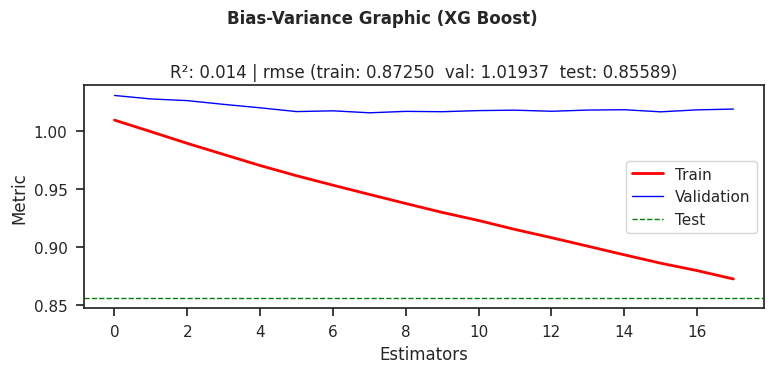

In [22]:
agent.fit(path="../saved")

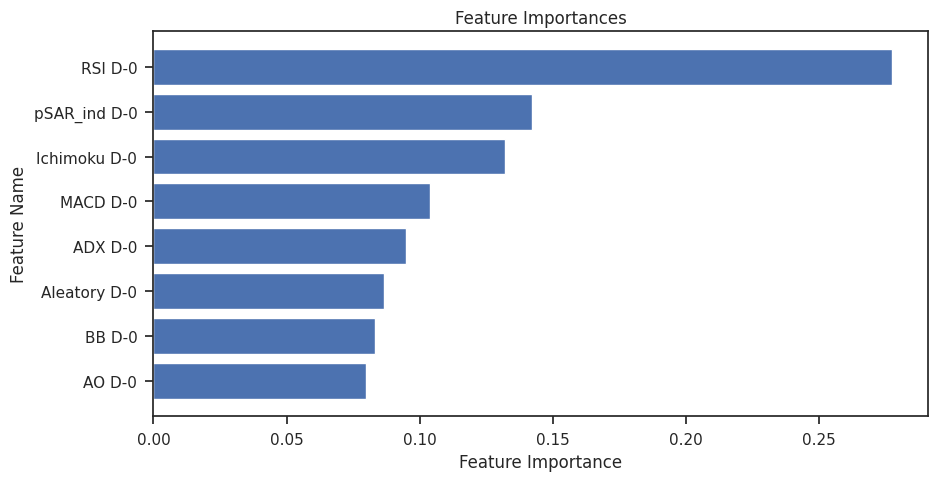

In [23]:
agent.feature_importances()

### Real Result

Inference time: 58.25 milliseconds (500 register(s))


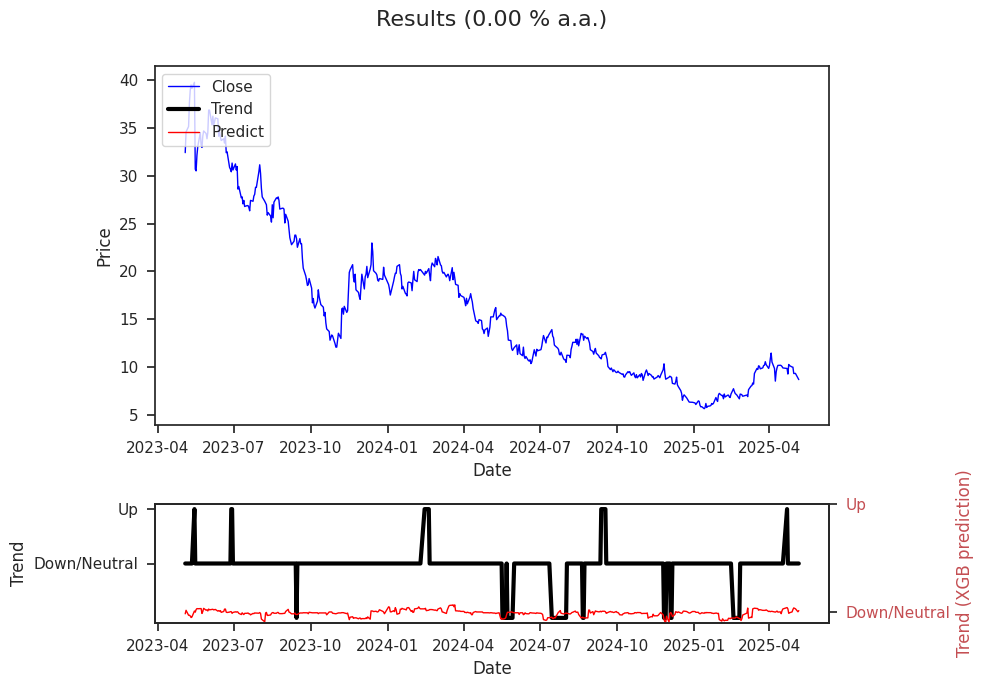

In [24]:
results = agent.predict(sample, path="../", return_df=True)